In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from konlpy.tag import Okt

twitter = Okt()
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [2]:
df=pd.read_csv('after_cleansing_with_likes.csv')
df.head()

,Unnamed: 0,comment,num_likes
0,0,한두 명만 들여라,0
1,1,정우성이 수용하면 되겠네,0
2,2,환대하시는 분들 집에 거주하게 하면 어떨지요 이슬람 종교색이 너무 강하다 절대 안 된다,0
3,3,왜 환대를 해야 하는지는 모르겠음 미군 감시하에 이탈 없이 지내면 상관없음 괜히 탈...,4
4,4,우리 허락받고 논의해야 될 문제를 자기들 책임지기 싫어서 동맹국한테 떠넘기기 하네 ...,3


In [3]:
print(df.shape)
df=df.drop_duplicates(['comment'],keep='first') #중복값 제거
print(df.shape)

(4971, 3)
(4887, 3)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4887 entries, 0 to 4970
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4887 non-null   int64 
 1   comment     4886 non-null   object
 2   num_likes   4887 non-null   object
dtypes: int64(1), object(2)
memory usage: 152.7+ KB


In [7]:
df.isnull().sum()

Unnamed: 0    0
comment       1
num_likes     0
dtype: int64

In [12]:
df['comment'][df['comment'].isna()]

1859    NaN
Name: comment, dtype: object

In [16]:
df=df.drop(1859) #결측치 제거

In [17]:
print(df.shape)

(4886, 3)


In [18]:
df['comment'].apply(str) #string으로 변환

0                                               한두 명만 들여라
1                                           정우성이 수용하면 되겠네
2        환대하시는 분들 집에 거주하게 하면 어떨지요 이슬람 종교색이 너무 강하다 절대 안 된다
3       왜 환대를 해야 하는지는 모르겠음 미군 감시하에 이탈 없이 지내면 상관없음 괜히 탈...
4       우리 허락받고 논의해야 될 문제를 자기들 책임지기 싫어서 동맹국한테 떠넘기기 하네 ...
                              ...                        
4966    우리 대한민국 국민들의 안전과 생명을 위해 절대로 무슬림 난민들을 받아들이면 안 됩...
4967                                     좀 생각하고 말 내뱉어라 하 
4968                                           검토만 하고 끝내라
4969                                     김성은 진피 아이 조시나 까라
4970                                               까라면 까라
Name: comment, Length: 4886, dtype: object

빈도

In [19]:
search_keyword=['난민','아프간','종교','반대','미국','이슬람','절대',
               '찬성','환영']
for keyword in search_keyword:
    df[keyword]=df['comment'].str.contains(keyword)

In [20]:
df.head()

,Unnamed: 0,comment,num_likes,난민,아프간,종교,반대,미국,이슬람,절대,찬성,환영
0,0,한두 명만 들여라,0,False,False,False,False,False,False,False,False,False
1,1,정우성이 수용하면 되겠네,0,False,False,False,False,False,False,False,False,False
2,2,환대하시는 분들 집에 거주하게 하면 어떨지요 이슬람 종교색이 너무 강하다 절대 안 된다,0,False,False,True,False,False,True,True,False,False
3,3,왜 환대를 해야 하는지는 모르겠음 미군 감시하에 이탈 없이 지내면 상관없음 괜히 탈...,4,False,False,False,True,False,False,False,False,False
4,4,우리 허락받고 논의해야 될 문제를 자기들 책임지기 싫어서 동맹국한테 떠넘기기 하네 ...,3,False,True,False,False,True,False,False,False,False


In [21]:
#키워드가 들어가는 댓글의 개수
df[search_keyword].sum().sort_values(ascending=False)

난민     1301
이슬람     736
아프간     524
반대      455
미국      449
종교      342
절대      308
찬성      137
환영       28
dtype: int64

In [24]:
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
                             ngram_range=(1,4), # BOW의 단위 갯수의 범위를 지정합니다.
                             max_features = 5000 # 만들 피처의 수, 단어의 수
                            )
vectorizer

CountVectorizer(max_features=5000, min_df=2, ngram_range=(1, 4))

In [25]:
# 벡터화
feature_vector = vectorizer.fit_transform(df['comment'])
feature_vector.shape

(4886, 5000)

In [26]:
# vectorizer 에서 get_feature_names 를 추출합니다.
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

5000


['100', '100년', '100만', '100명', '10년', '10만', '10명', '10명씩', '10월', '123']

In [27]:
# 각 단어마다 등장하는 단어에 빈도수가 표현됩니다. 0 은 등장하지 않음을 의미합니다.
pd.DataFrame(feature_vector[:10].toarray(), columns=vocab).head()

,100,100년,100만,100명,10년,10만,10명,10명씩,10월,123,...,힘들고,힘들다,힘들어,힘들어 죽겠는데,힘들어요,힘듦,힘으로,힘은,힘을,힘이
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# 위에서 구한 단어벡터를 더하면 단어가 전체에서 등장하는 횟수를 알 수 있습니다.
# 벡터화 된 피처를 확인해 봄
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0)
    
df_freq = pd.DataFrame(dist, columns=vocab)
df_freq

,100,100년,100만,100명,10년,10만,10명,10명씩,10월,123,...,힘들고,힘들다,힘들어,힘들어 죽겠는데,힘들어요,힘듦,힘으로,힘은,힘을,힘이
0,4,4,5,5,4,4,9,10,4,4,...,9,14,18,3,5,3,7,3,8,6


In [29]:
# 행과 열의 축을 T로 바꿔주고 빈도수로 정렬합니다.
df_freq.T.sort_values(by=0, ascending=False).head(30)

,0
난민,896
이슬람,524
나라,460
아프간,383
한국,340
절대,311
하는,292
우리,276
있는,262
우리나라,238


In [30]:
# ["comment", "freq"] 라는 컬럼명을 주어 위에서 만든 데이터프레임을 변환
df_freq_T = df_freq.T.reset_index()
df_freq_T.columns = ["comment", "freq"]
df_freq_T.head()

,comment,freq
0,100,4
1,100년,4
2,100만,5
3,100명,5
4,10년,4


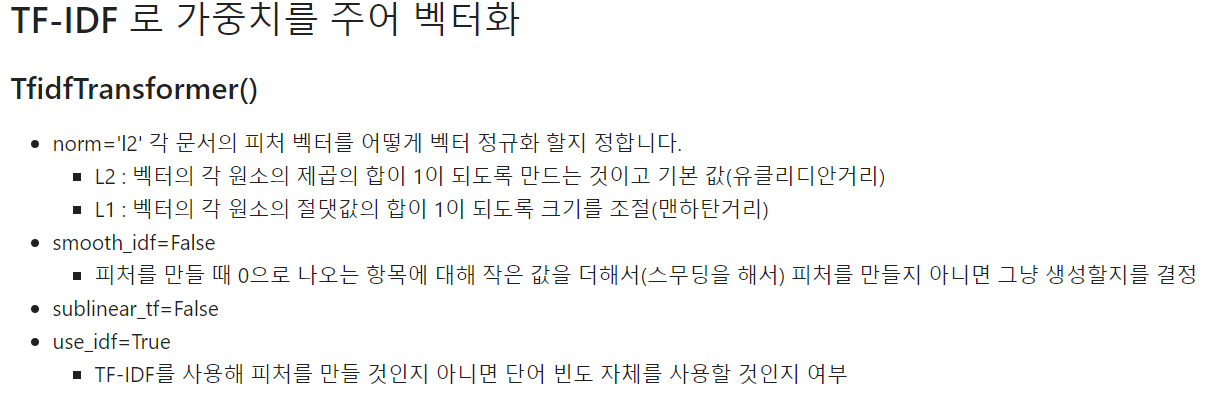

In [32]:
# TfidfTransformer 를 불러와서 가중치를 주어 벡터화 합니다.
# transformer 라는 변수로 저장하고 재사용합니다.
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

In [33]:
# fit_transform 으로 가중치를 적용하고 결과를 feature_tfidf 로 받습니다.
feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf.shape

(4886, 5000)

In [34]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 one-hot-vector에 TF-IDF 가중치 반영한 결과를 봅니다.
# feature_tfidf.toarray() 로 배열로 만들고  데이터 프레임을 만들어 tfidf_freq 라는 변수에 할당해서 봅니다.
tfidf_freq = pd.DataFrame(feature_tfidf.toarray(), columns=vocab)
tfidf_freq.head() 

,100,100년,100만,100명,10년,10만,10명,10명씩,10월,123,...,힘들고,힘들다,힘들어,힘들어 죽겠는데,힘들어요,힘듦,힘으로,힘은,힘을,힘이
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# tfidf_freq를 sum 으로 가중치를 다 더해줍니다.
df_tfidf = pd.DataFrame(tfidf_freq.sum())
df_tfidf_top = df_tfidf.sort_values(by=0, ascending=False)
df_tfidf_top.head(30)

,0
난민,111.796062
이슬람,77.149022
나라,65.725333
절대,56.202368
아프간,53.632754
한국,48.432929
우리,45.109400
진짜,44.760994
반대,43.153882
우리나라,40.638515


In [36]:
# 중간에 생략되는 단어를 자세히 보고자 할 때
for t in df_tfidf_top.index[:30]:
    print(t)

난민
이슬람
나라
절대
아프간
한국
우리
진짜
반대
우리나라
하는
있는
그냥
우리가
미국이
다른
미국
마라
지금
같은
된다
하고
무슨
사람들
한국에
무슬림
이슬람은
한다
난민을
난민은
